In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import equilibriumfuns
from equilibriumfuns import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
#from helperfuns import *

In [3]:
#%%writefile helperfuns.py
import numpy as np
import pandas as pd
import scipy.stats as scs

# Helper functions
def Kfun(s, norm = scs.norm(0.2,1)):
    # Finds K, the probability of socially learning
    #input: d real positive numbe or -1, and a normmal curve
    #output K
    K = norm.cdf(s) - norm.cdf(-s)
    return(K)
# find pc given s and the normal curve
def pcfun(s, norm = scs.norm(0.2,1)):
    # Finds pc, the probability of individual learning correctly
    #input: d real positive numbe or -1, and a normmal curve
    #output pc
    pc = 1 - norm.cdf(s)
    return(pc)

# find pw given s and the normal curve
def pwfun(s,norm = scs.norm(0.2,1)):
    # Finds pw, the probability of individual learning incorrectly
    #input: d real positive numbe or -1, and a normmal curve
    #output pw
    pw = norm.cdf(-s)
    return(pw)


# The resource relative density recursion
def r_fun(r, N, u,beta, learn_r_u,learn_r_x, eta = 1):
    # The recursion for resource $i$
    x = 1 - u
    
    tot_learn_r = u*learn_r_u + x*learn_r_x
    r_next = r*(1 + eta - beta*N*tot_learn_r)/(1+eta*r)
    if r_next < 0:
        r_next = 0
        print('CP extinct')
    return(r_next)

# population size of predators in the next generation 
def PopSize(N_t,W,delta):
    # W is mean population fitness
    # delta is the death rate
    N_tplus1 = N_t*(W-delta)
    # to avoid runtime issues
    if N_tplus1 > 1E9:
        return(1E9)
    elif N_tplus1 <1E-9:
        return(0)
    else:
        return(N_tplus1)



def NextGen(u_r,u_R,x_r,x_R,N, r,R,beta,delta,K,pc,dk,dpc):
#    u_r,u_R = uvec
    u = u_r + u_R; x = 1 - u;
#    x_r,x_R = xvec
    p_r = u_r + x_r
    eta = 1
    
    learn_r_u = K*p_r + pc*(r/(r+R)) # no longer relevant - if r + R > 0 else K*p_r
    learn_r_x = (K+dk)*p_r + (pc+dpc)*(r/(r+R)) # no longer relevant - if r + R > 0 else (K+dk)*p_r
    
    Wu_r = u*learn_r_u*(1+r)
    Wu_R = u*(1-learn_r_u)*(1+R)
    #Wx_r = x*learn_r_x*(1+r)
    #Wx_R = x*(1-learn_r_x)*(1+R)
    W = Wu_r + Wu_R #+ Wx_r + Wx_R
    # need to check this with my eqn
    u_r = Wu_r/W
    u_R = Wu_R/W
    uvec_new = [u_r,u_R]
    #uvec_new = np.array([Wu_r,Wu_R])/W
    xvec_new = [0,0] # np.array([Wx_r,Wx_R])/W
    
    tot_learn_r = u*learn_r_u + x*learn_r_x
    r_next = r*(1 + eta - beta*N*tot_learn_r)/(1+eta*r)
    r_new = r_next if r_next > 0 else 0
    
    N_new = PopSize(N,W,delta)
    return(u_r,u_R, x_r,x_R,W,N_new, r_new)

def calculate_eq_r(K,pc,delta,R):
    # Calculates the nonzero r equilibrium
    
    if R>delta:
        return(np.NaN)
    
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta) -1) - R*pc
    c = -R*(delta-R)*(1-K/(1+delta))
    if b**2 - 4*a*c > 0:
        return((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    else:
        return(np.NaN)

def GetXsteps(param_grid, tsteps):
    u_r_init = param_grid.u_r_init.values
    r_init = param_grid.r_init.values
    
def iterate_row(row,tsteps):
    # iterates from the initial point. tsteps generations
    # row could also be a dataframe
    u_r = row.u_r_init.values
    u_R = 1 - u_r
    r = row.r_init.values
    n = r.size
    x_r = np.zeros(n)
    x_R = np.zeros(n)
    N = row.N_init.values
    R = row.R.values
    beta = row.beta.values; delta = row.delta.values
    K = row.K.values; pc = row.pc.values
    NextGenV = np.frompyfunc(NextGen,13,7)
    for t in range(1,tsteps):
        out = NextGenV(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,0,0)
        u_r, u_R, x_r,x_R,W,N, r = np.array(list(out),dtype=float)
    row.u_r_eq = u_r
    row.r_eq = r
    row.N_eq = N
    row.W_eq = W
    return(row)

def get_trajectory(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,tsteps, dk = 0, dpc = 0):
    # TO-DO: Check this works!!!
    u_r_vec = np.zeros(tsteps); u_r_vec[0] = u_r
    u_R_vec = np.zeros(tsteps); u_R_vec[0] = u_R
    x_r_vec = np.zeros(tsteps); x_r_vec[0] = x_r
    x_R_vec = np.zeros(tsteps); x_R_vec[0] = x_R
    N_vec = np.zeros(tsteps); N_vec[0] = N;
    r_vec = np.zeros(tsteps); r_vec[0] = r;
    NextGenV = np.frompyfunc(NextGen,13,7)
    for t in range(1,tsteps):
        out = NextGenV(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,dk,dpc)
        u_r, u_R, x_r, x_R, W, N, r = np.array(list(out), dtype=float)
        u_r_vec[t], u_R_vec[t], x_r_vec[t], x_R_vec[t], N_vec[t], r_vec[t] = u_r, u_R, x_r, x_R, N, r
    return(u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec)
    
    
    

# Check 1

In [76]:
delta = 0.2
R = 0.1
s = 1
mu = 0
beta = 0.01
N_init = 100

u_r_vals = np.array([0.01,0.2,0.45,0.7,0.98])
# u_R_vals = 1 - u_r_vals
r_init_vals = np.array([0.05, 0.1, 0.48, 0.7, 0.99 ])

u_mesh, r_mesh = np.meshgrid(u_r_vals, r_init_vals)
u_vec = np.ndarray.flatten(u_mesh)
r_vec = np.ndarray.flatten(r_mesh)
n = r_vec.size
df1 = pd.DataFrame(data={'u_r_init':u_vec, 'r_init': r_vec, 'N_init':N_init, 'R':R, 'beta':beta,
                        'delta':delta, 'mu': mu, 's': s, 'K': Kfun(s,scs.norm(mu)), 'pc': pcfun(s,scs.norm(mu)),
                        'u_r_eq':np.zeros(n), 'r_eq':np.zeros(n), 'N_eq':np.zeros(n), 'W_eq':np.zeros(n)})

In [67]:
beta

0.1

In [77]:
row = pd.DataFrame(data={'u_r_init':0.5, 'r_init': 1, 'N_init':100, 'R':R, 'beta':.01,
                        'delta':delta, 'mu': mu, 's': s, 'K': Kfun(s,scs.norm(mu)), 'pc': pcfun(s,scs.norm(mu)),
                        'u_r_eq':0, 'r_eq':0, 'N_eq':0, 'W_eq':0},index=[0])

In [85]:
iterate_row(df1,1000)

,u_r_init,r_init,N_init,R,beta,delta,mu,s,K,pc,u_r_eq,r_eq,N_eq,W_eq
0,0.01,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
1,0.20,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
2,0.45,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
3,0.70,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
4,0.98,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
5,0.01,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
6,0.20,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
7,0.45,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
8,0.70,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
9,0.98,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2


In [86]:
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
get_r_hat_vec(df1.K.values,df1.pc.values,df1.delta.values,df1.R.values)

array([array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan])], dtype=object)

# Check 2

In [21]:
#NextGen(u_r,u_R,x_r,x_R,N, r,R,beta,delta,K,pc,dk,dpc)
NextGenV = np.frompyfunc(NextGen,13,7)

In [22]:
out = NextGenV(u_vec, 1 - u_vec, np.zeros(len(u_vec)),np.zeros(len(u_vec)), 
               N_init,r_vec, R, beta, delta, Kfun(s,scs.norm(mu)),pcfun(s,scs.norm(mu)), 0, 0)

In [94]:
u_r_vals = [0.01,0.2,0.45,0.7,0.98]
# u_R_vals = 1 - u_r_vals
r_init_vals = [0.05, 0.1, 0.48, 0.7, 0.99 ]
R_vals = [0.01, 0.25, 0.55, 0.9]
N_init = [10,50,100,150]
beta_vals = [0,0.005,0.01] # chosen so that r = 1 - beta*N*L >= 0 if L = 1, N <=100.
delta_vals = [0.02, 0.3, 0.8]
mu_vals = [-1,0,1]
s_vals = [0,1,3]
u_mesh, r_mesh, N_mesh, R_mesh, beta_mesh, delta_mesh, mu_mesh, s_mesh = np.meshgrid(u_r_vals, r_init_vals, N_init, R_vals, 
                                                                             beta_vals, delta_vals, mu_vals, s_vals)
u_r_vec, r_vec, N_vec, R_vec, beta_vec, delta_vec, mu_vec, s_vec = [np.ndarray.flatten(mat) for mat in [u_mesh,r_mesh, N_mesh,
                                                                                               R_mesh, beta_mesh, 
                                                                                               delta_mesh, mu_mesh, 
                                                                                               s_mesh]]
u_R_vec = 1 - u_r_vec
Kvec = Kfun(s_vec, scs.norm(mu_vec))
pcvec = pcfun(s_vec, scs.norm(mu_vec))
n = len(Kvec)
df = pd.DataFrame(data = {'u_r_init': u_r_vec, 'r_init': r_vec, 'N_init':N_vec,'R':R_vec, 'beta':beta_vec, 
                          'delta':delta_vec, 'mu':mu_vec, 's':s_vec, 'K': Kvec, 'pc':pcvec,
                         'u_r_eq':np.zeros(n), 'r_eq':np.zeros(n), 'N_eq':np.zeros(n), 'W_eq':np.zeros(n)})

In [96]:
df_try = df.sample(10)

In [165]:
df_out = iterate_row(df_try,100000)

In [166]:
df_out_reached_eq = df_out.query('W_eq-1 - delta > -0.0000000001 & W_eq-1 - delta < 0.0000000001')

In [167]:
df_out_reached_eq

,u_r_init,r_init,N_init,R,beta,delta,mu,s,K,pc,u_r_eq,r_eq,N_eq,W_eq
18177,0.98,0.48,10,0.01,0.005,0.02,1,0,0.00000,0.841345,0.613963,0.026390,319.143017,1.02
25106,0.98,0.70,50,0.25,0.010,0.80,0,3,0.99730,0.001350,0.996227,0.803005,19.807151,1.80
14821,0.20,0.48,50,0.55,0.010,0.80,1,1,0.47725,0.500000,0.696246,0.936247,9.849717,1.80
13338,0.01,0.48,50,0.01,0.010,0.02,-1,0,0.00000,0.158655,0.149607,0.080828,651.029228,1.02


In [168]:
K,pc,delta,R= np.transpose(df_out_reached_eq[["K","pc","delta","R"]].values)
result = get_r_hat_vec(K,pc,delta,R)

In [169]:
np.transpose(np.array(list(result)))

array([[0.02638967, 0.80300468, 0.93624735, 0.08082777],
       [       nan,        nan,        nan,        nan]])

In [157]:
df_out_reached_eq[["K","pc","delta","R"]]

,K,pc,delta,R
18177,0.00000,0.841345,0.02,0.01
25106,0.99730,0.001350,0.80,0.25
14821,0.47725,0.500000,0.80,0.55
13338,0.00000,0.158655,0.02,0.01


# Extinction of Predators

Here, I want to see under which conditions predators will go extinct

In [46]:
u_r_vals = [0.01,0.2,0.45,0.7,0.98]
# u_R_vals = 1 - u_r_vals
r_init_vals = [0.05, 0.1, 0.48, 0.7, 0.99 ]

delta = 0.3
R_vals = [0.01, 0.2, 0.6, 0.9]

beta_vals = [0,0.005,0.01] # chosen so that r = 1 - beta*N*L >= 0 if L = 1, N <=100.

mu_vals = [-1,0,1]
s_vals = [0,1,3]

N = 100
R = R_vals[0]; beta = beta_vals[0]; mu = mu_vals[0]; s = s_vals[0]; u_r = u_r_vals[1]; r = r_init_vals[3]
u_R = 1 - u_r; x_r = 0; x_R = 0

In [126]:
tsteps = 10
s = 1
K = Kfun(s,scs.norm(mu))
pc = pcfun(s,scs.norm(mu))
dk = 0; dpc = 0

Above I tried to have points colored by the u_r value. However, this seems too confusing.

In [88]:
def plot_colourline(x,y,c,minc=None,maxc=None, ax=None, cmapAnchor = True, cmap = None, add_arrow = True):
    if minc == None:
        minc = np.min(c)
        maxc = np.max(c)
        #ptpc = np.ptp(c)
    c_orig = c  
    if cmap == None:
        c = cm.viridis((c-minc)/(maxc-minc))
    else:
        c = cmap((c-minc)/(maxc-minc))

    
    if ax == None:
        ax = plt.gca()
    # set up a scatter plot and clear it just so I have something to feed the colorbar thing
    if cmapAnchor:
        CS3 = ax.scatter(x,y,c=c)
        ax.cla()
    else:
        CS3 = None
    lw = 3.0
    for i in np.arange(len(x)-1):
        
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i],linewidth=lw)
    if add_arrow==True:
        ax.quiver(x[1],y[1],x[2] - x[1],y[2] - y[1],
                  scale_units='xy', angles='xy', scale=1,color=c[1],
                  width=lw/1000, headwidth=10, headlength=10)

        
    return(CS3)

In [79]:
3.0/100

0.03

<ipython-input-89-e68fe08d4939>:45: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(cb_anchor)
<ipython-input-89-e68fe08d4939>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(yticklabs)


[Text(1, 0.0, '0.000'),
 Text(1, 0.1, '0.060'),
 Text(1, 0.2, '0.120'),
 Text(1, 0.30000000000000004, '0.180'),
 Text(1, 0.4, '0.240'),
 Text(1, 0.5, '0.300'),
 Text(1, 0.6000000000000001, '0.360'),
 Text(1, 0.7000000000000001, '0.420'),
 Text(1, 0.8, '0.480')]

<Figure size 432x288 with 0 Axes>

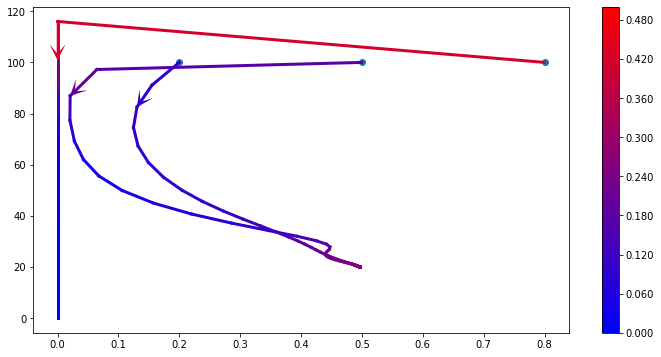

In [89]:
beta = 0.1
delta = 0.2
mu = -0.5
R = 0.1
s = 1
K = Kfun(s,scs.norm(mu))
pc = pcfun(s,scs.norm(mu))

N=100
rvals = [0.2, 0.8, 0.5]
uvals = [0.1, 0.5, 0.2]

trajs = [get_trajectory(u_r, 1 - u_r, 0,0,N,r,R,beta,delta,K,pc,100) for u_r, r in zip(uvals, rvals)]
u_r_vecs = [traj[0] for traj in trajs]
N_vecs = [traj[4] for traj in trajs]
r_vecs = [traj[-1] for traj in trajs]





# need something to feed the colorbar
all_u = np.ndarray.flatten(np.array(u_r_vecs))
all_N = np.ndarray.flatten(np.array(N_vecs))
all_r = np.ndarray.flatten(np.array(r_vecs))

minu = all_u.min()
maxu = all_u.max()+.1

mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
cb_anchor = plt.imshow((np.array(u_r_vecs) - minu)/(maxu-minu),cmap=mymap)

plt.clf()

# set up plot
fig, ax = plt.subplots(1,1, figsize = [12,6])

for i in range(0,3):
    r_vec = r_vecs[i]
    N_vec = N_vecs[i]
    cs = plot_colourline(r_vec,N_vec,u_r_vecs[i],minc=minu,maxc=maxu,ax=ax, cmapAnchor=False, cmap = mymap)

ax.scatter(rvals,[100,100,100])
# set up colorbar
cb = fig.colorbar(cb_anchor)

yticks_cb = cb.ax.get_yticks()
yticks = yticks_cb*(maxu-minu) + minu
yticklabs = ['%0.3f'%tick for tick in yticks]
cb.ax.set_yticklabels(yticklabs)